In [1]:
import numpy as np
import pandas as pd
import cooler
import cooltools
import pybedtools

In [2]:
# Load the BED file
enhancer_bed_file ="/lustre/home/acct-medlqian/medlqian-loop3/database/enhancer/OR_63_enhancers.bed"
enhancer_bed = pybedtools.BedTool(enhancer_bed_file)
print(enhancer_bed)

chr1	92545930	92546383	Rhodes
chr1	173190529	173190944	Kea
chr1	173212162	173212558	Kythnos
chr1	173265692	173266108	Serifos 
chr1	174035928	174036370	Astypalea 
chr1	174342508	174342880	Santorini
chr10	78617938	78618355	Aigina
chr10	128978758	128979150	Poros
chr10	130098477	130098928	Kithira
chr11	49575369	49575772	Skyros
chr11	50999121	50999596	Symi
chr11	58739096	58739523	Souda
chr11	58810711	58811177	Andros
chr11	59575822	59576267	Delos
chr11	74036072	74036525	Crete
chr11	87897054	87897472	Naxos
chr11	87907100	87907510	Kasos
chr11	87937182	87937587	Sifnos
chr13	21341098	21341482	Tils
chr13	21343517	21343943	Halki
chr13	65163225	65163621	Agathonisi
chr14	50758662	50759084	Lesvos
chr14	52547909	52548295	H
chr14	54284841	54285234	Agistri
chr14	54304092	54304455	Salamina
chr15	98263364	98263753	Paxi
chr16	3781277	3781653	Kastelorizo
chr16	58956958	58957359	Gavdos
chr17	37543932	37544486	Tilos
chr19	12830815	12831219	Rho
chr19	14090464	14090854	Oinouses
chr19	14096326	14096708	Tinos
chr

In [3]:
Het_clr = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.valid_pairs.5000.zoomify.mcool::resolutions/50000")


In [4]:
# 简单方法：直接处理BedTool对象
import pandas as pd
import numpy as np

def map_bedtool_to_bins(bedtool_obj, clr):
    """
    直接从BedTool对象映射到Hi-C bins
    """
    # 获取bins信息
    bins = clr.bins()[:]
    
    # 存储映射结果
    mappings = []
    
    # 遍历BedTool中的每个区间
    for i, interval in enumerate(bedtool_obj):
        chrom = interval.chrom
        start = interval.start
        end = interval.end
        midpoint = (start + end) // 2
        
        # 找到同一染色体的bins
        chrom_bins = bins[bins['chrom'] == chrom]
        
        if len(chrom_bins) > 0:
            # 找到包含中点的bin
            containing_bins = chrom_bins[
                (chrom_bins['start'] <= midpoint) & (chrom_bins['end'] > midpoint)
            ]
            
            if len(containing_bins) > 0:
                # 找到了包含中点的bin
                bin_info = containing_bins.iloc[0]
                bin_idx = bin_info.name
            else:
                # 没找到包含中点的bin，找最近的
                distances = np.abs(chrom_bins['start'] - midpoint)
                closest_idx = distances.idxmin()
                bin_info = chrom_bins.loc[closest_idx]
                bin_idx = bin_info.name
            
            mappings.append({
                'enhancer_idx': i,
                'enhancer_chrom': chrom,
                'enhancer_start': start,
                'enhancer_end': end,
                'enhancer_midpoint': midpoint,
                'bin_idx': bin_idx,
                'bin_chrom': bin_info['chrom'],
                'bin_start': bin_info['start'],
                'bin_end': bin_info['end']
            })
        else:
            # 该染色体在bins中不存在
            mappings.append({
                'enhancer_idx': i,
                'enhancer_chrom': chrom,
                'enhancer_start': start,
                'enhancer_end': end,
                'enhancer_midpoint': midpoint,
                'bin_idx': None,
                'bin_chrom': None,
                'bin_start': None,
                'bin_end': None
            })
    
    return pd.DataFrame(mappings)

# 使用方法
print("开始映射enhancer到bins...")
enhancer_to_bin_mapping = map_bedtool_to_bins(enhancer_bed, Het_clr)

print("映射结果:")
print(enhancer_to_bin_mapping.head(10))
print(f"\n总共 {len(enhancer_to_bin_mapping)} 个enhancer")
print(f"成功映射: {enhancer_to_bin_mapping['bin_idx'].notna().sum()} 个")
print(f"映射失败: {enhancer_to_bin_mapping['bin_idx'].isna().sum()} 个")

# 查看映射失败的染色体
if enhancer_to_bin_mapping['bin_idx'].isna().sum() > 0:
    failed_chroms = enhancer_to_bin_mapping[enhancer_to_bin_mapping['bin_idx'].isna()]['enhancer_chrom'].unique()
    print(f"映射失败的染色体: {failed_chroms}")

# 获取成功映射的bin索引列表
successful_bins = enhancer_to_bin_mapping[enhancer_to_bin_mapping['bin_idx'].notna()]
bin_indices = successful_bins['bin_idx'].tolist()

print(f"\n成功映射的bin索引数量: {len(bin_indices)}")
print(f"前10个bin索引: {bin_indices[:10]}")

# 检查是否有重复的bin（多个enhancer映射到同一个bin）
unique_bins = len(set(bin_indices))
print(f"唯一bin数量: {unique_bins}")
if unique_bins < len(bin_indices):
    print(f"有 {len(bin_indices) - unique_bins} 个重复映射")

开始映射enhancer到bins...
映射结果:
   enhancer_idx enhancer_chrom  enhancer_start  enhancer_end  \
0             0           chr1        92545930      92546383   
1             1           chr1       173190529     173190944   
2             2           chr1       173212162     173212558   
3             3           chr1       173265692     173266108   
4             4           chr1       174035928     174036370   
5             5           chr1       174342508     174342880   
6             6          chr10        78617938      78618355   
7             7          chr10       128978758     128979150   
8             8          chr10       130098477     130098928   
9             9          chr11        49575369      49575772   

   enhancer_midpoint  bin_idx bin_chrom  bin_start    bin_end  
0           92546156     1850      chr1   92500000   92550000  
1          173190736     3463      chr1  173150000  173200000  
2          173212360     3464      chr1  173200000  173250000  
3          1

In [5]:
unique_mapping = enhancer_to_bin_mapping[enhancer_to_bin_mapping['bin_idx'].notna()].drop_duplicates(subset='bin_idx', keep='first')
print(f"\n去重后保留的enhancer数量: {len(unique_mapping)}")
print(unique_mapping)


去重后保留的enhancer数量: 59
    enhancer_idx enhancer_chrom  enhancer_start  enhancer_end  \
0              0           chr1        92545930      92546383   
1              1           chr1       173190529     173190944   
2              2           chr1       173212162     173212558   
3              3           chr1       173265692     173266108   
4              4           chr1       174035928     174036370   
5              5           chr1       174342508     174342880   
6              6          chr10        78617938      78618355   
7              7          chr10       128978758     128979150   
8              8          chr10       130098477     130098928   
9              9          chr11        49575369      49575772   
10            10          chr11        50999121      50999596   
11            11          chr11        58739096      58739523   
12            12          chr11        58810711      58811177   
13            13          chr11        59575822      59576267   
14 

In [6]:
unique_mapping.to_csv('../files_v1/enhancer_unique_mapping_50kb.csv', index=False)

In [7]:
for key, value in Het_clr.info.items():
    print(f"{key}: {value}")

bin-size: 50000
bin-type: fixed
creation-date: 2025-06-28T16:41:55.221428
format: HDF5::Cooler
format-url: https://github.com/open2c/cooler
format-version: 3
generated-by: cooler-0.9.2
genome-assembly: unknown
metadata: {}
nbins: 54650
nchroms: 66
nnz: 92799094
storage-mode: symmetric-upper
sum: 202632615


In [8]:
Het_pixels = Het_clr.pixels()[:]
Het_bins = Het_clr.bins()[:]
Het_w = Het_bins["weight"].values

Het_bin1_w = Het_w[Het_pixels["bin1_id"].values]
Het_bin2_w = Het_w[Het_pixels["bin2_id"].values]
Het_balanced_count = Het_pixels["count"].values * Het_bin1_w * Het_bin2_w

Het_total_balanced_count = np.nansum(Het_balanced_count)
print(Het_total_balanced_count)

32713.819249532262


In [9]:
def extract_contacts_from_unique_bins_indices(unique_mapping, clr):
    """
    使用unique bins的索引直接提取contact matrix
    """
    # 获取unique bin索引
    unique_bin_indices = unique_mapping['bin_idx'].tolist()
    
    print(f"使用bin索引提取 {len(unique_bin_indices)} x {len(unique_bin_indices)} contact matrix")
    
    # cooler不支持列表索引，需要逐个提取或使用其他方法
    n_bins = len(unique_bin_indices)
    contact_matrix = np.zeros((n_bins, n_bins))
    
    # 获取全矩阵然后筛选 (如果数据不太大)
    try:
        # 先尝试获取包含所有unique bins的最小矩阵范围
        min_idx = min(unique_bin_indices)
        max_idx = max(unique_bin_indices)
        
        # 提取大矩阵块
        full_matrix = clr.matrix(balance=True, sparse=False)[min_idx:max_idx+1, min_idx:max_idx+1]
        
        # 调整索引
        adjusted_indices = [idx - min_idx for idx in unique_bin_indices]
        
        # 提取子矩阵
        contact_matrix = full_matrix[np.ix_(adjusted_indices, adjusted_indices)]
        
    except Exception as e:
        print(f"块提取失败: {e}")
        print("使用逐个提取方法...")
        # 退回到逐个提取
        for i, idx_i in enumerate(unique_bin_indices):
            for j, idx_j in enumerate(unique_bin_indices):
                contact_matrix[i, j] = clr.matrix(balance=True)[idx_i, idx_j]
            if (i + 1) % 50 == 0:
                print(f"已处理 {i + 1}/{n_bins} 行")
    
    return contact_matrix, unique_bin_indices

Het_all_enhancer_contacts, Het_unique_info = extract_contacts_from_unique_bins_indices(unique_mapping, Het_clr)


使用bin索引提取 59 x 59 contact matrix


In [19]:
Het_all_enhancer_normalized_contacts = (Het_all_enhancer_contacts / Het_total_balanced_count) * 1e9
np.savetxt('../files/Het_GI_rpb_50kb.txt', 
           Het_all_enhancer_normalized_contacts, 
           fmt='%.6f', 
           delimiter='\t')
print(np.nanmax(Het_all_enhancer_normalized_contacts))
print(np.nanmedian(Het_all_enhancer_normalized_contacts))

6899.629292253222
5.677908233032169


In [22]:
Homo_clr = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.valid_pairs.5000.zoomify.mcool::resolutions/50000")

Homo_pixels = Homo_clr.pixels()[:]
Homo_bins = Homo_clr.bins()[:]
Homo_w = Homo_bins["weight"].values

Homo_bin1_w = Homo_w[Homo_pixels["bin1_id"].values]
Homo_bin2_w = Homo_w[Homo_pixels["bin2_id"].values]
Homo_balanced_count = Homo_pixels["count"].values * Homo_bin1_w * Homo_bin2_w

Homo_total_balanced_count = np.nansum(Homo_balanced_count)
print(Homo_total_balanced_count)

Homo_all_enhancer_contacts, Homo_unique_info = extract_contacts_from_unique_bins_indices(unique_mapping, Homo_clr)

Homo_all_enhancer_normalized_contacts = (Homo_all_enhancer_contacts / Homo_total_balanced_count) * 1e9
np.savetxt('../files/Homo_GI_rpb_50kb.txt', 
           Homo_all_enhancer_normalized_contacts, 
           fmt='%.6f', 
           delimiter='\t')
print(np.nanmax(Homo_all_enhancer_normalized_contacts))
print(np.nanmedian(Homo_all_enhancer_normalized_contacts))


33178.90407152158
使用bin索引提取 59 x 59 contact matrix
4814.229815314829
0.0


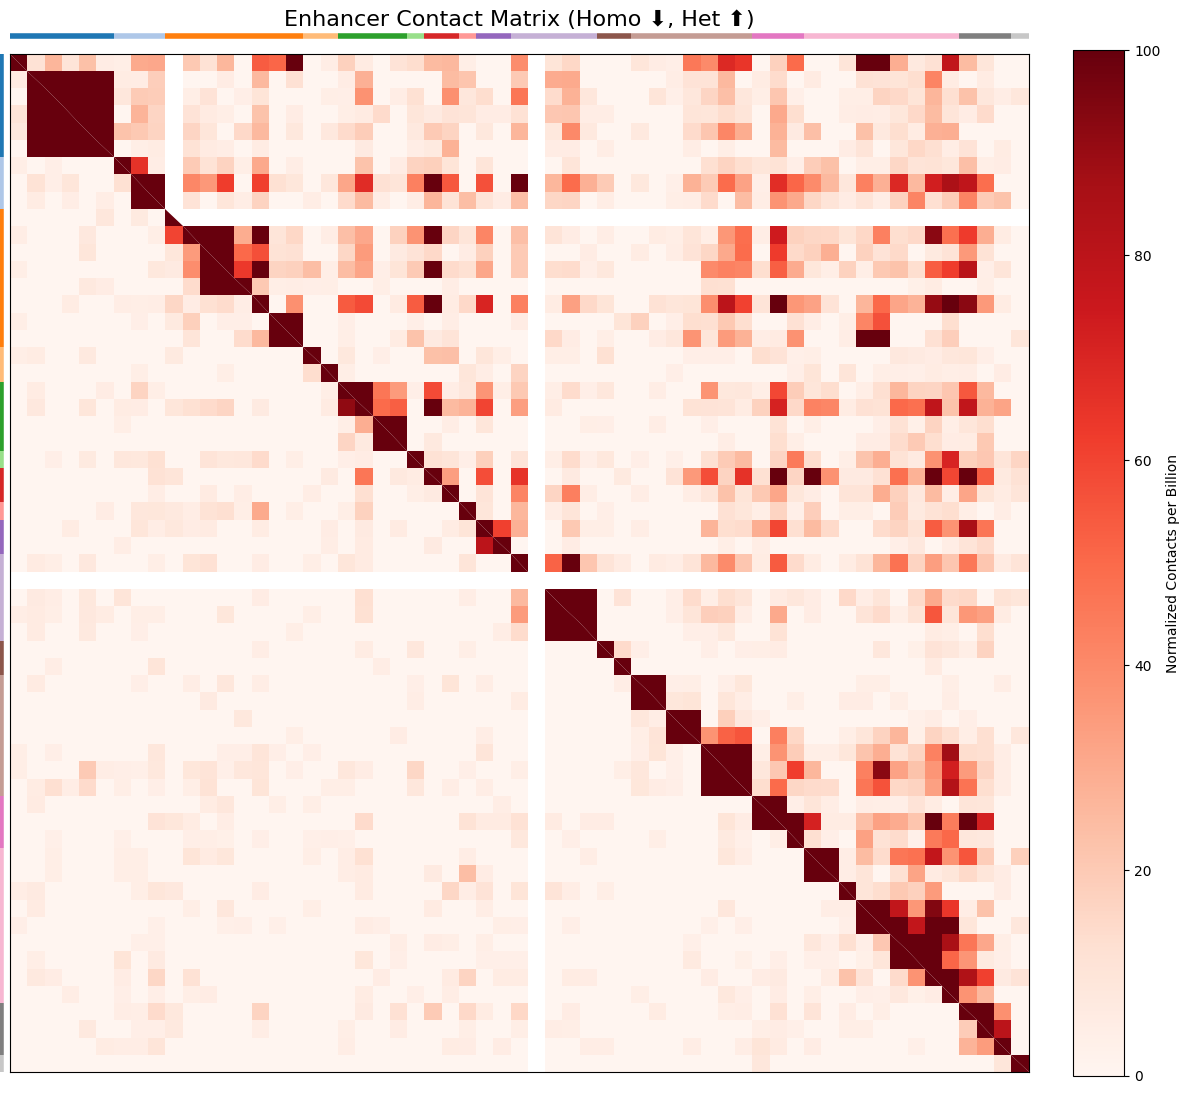

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Rectangle, Polygon

# 按照 enhancer 顺序提取染色体信息
chroms = unique_mapping['enhancer_chrom'].values

# 找到每个染色体的 bin 区间
chrom_order = list(dict.fromkeys(chroms))  # 保持出现顺序去重
chrom_color_map = {chrom: plt.cm.tab20(i % 20) for i, chrom in enumerate(chrom_order)}

# 找到每段染色体的起止坐标
chrom_regions = []
for chrom in chrom_order:
    idxs = np.where(chroms == chrom)[0]
    if len(idxs) > 0:
        chrom_regions.append((chrom, idxs.min(), idxs.max()))

# 参数
vmin = 0
vmax = 100

mat_homo = Homo_all_enhancer_normalized_contacts
mat_het = Het_all_enhancer_normalized_contacts
n = mat_homo.shape[0]

# === 绘图，替换原 imshow ===
fig, ax = plt.subplots(figsize=(12, 12))

# 逐格绘制（对角线分割为两个三角形）
for i in range(n):
    for j in range(n):
        if i < j:
            val = mat_het[i, j]
            if np.isnan(val):
                continue
            color = plt.cm.Reds(np.clip((val - vmin) / (vmax - vmin), 0, 1))
            ax.add_patch(Rectangle((j, i), 1, 1, facecolor=color, edgecolor='none'))
        elif i > j:
            val = mat_homo[i, j]
            if np.isnan(val):
                continue
            color = plt.cm.Reds(np.clip((val - vmin) / (vmax - vmin), 0, 1))
            ax.add_patch(Rectangle((j, i), 1, 1, facecolor=color, edgecolor='none'))
        else:
            val_het = mat_het[i, j]
            val_homo = mat_homo[i, j]
            if not np.isnan(val_het):
                color_het = plt.cm.Reds(np.clip((val_het - vmin) / (vmax - vmin), 0, 1))
                ax.add_patch(Polygon([[j, i], [j + 1, i], [j + 1, i + 1]], facecolor=color_het, edgecolor='none'))
            if not np.isnan(val_homo):
                color_homo = plt.cm.Reds(np.clip((val_homo - vmin) / (vmax - vmin), 0, 1))
                ax.add_patch(Polygon([[j, i], [j, i + 1], [j + 1, i + 1]], facecolor=color_homo, edgecolor='none'))

# 坐标轴设置
ax.set_xlim(0, n)
ax.set_ylim(n, 0)  # 反转Y轴，origin='upper'效果
ax.set_aspect('equal')

# 去掉 ticks 和标签
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Enhancer Contact Matrix (Homo ⬇, Het ⬆)', fontsize=16, pad=20)

# 染色体区域彩色条
# 染色体区域彩色条（覆盖完整格子）
for chrom, start, end in chrom_regions:
    color = chrom_color_map[chrom]
    ax.plot([start, end + 1], [-1, -1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)  # X轴上
    ax.plot([-0.5, -0.5], [start, end + 1], color=color, linewidth=4, solid_capstyle='butt', clip_on=False)  # Y轴上

# 颜色条
sm = ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Normalized Contacts per Billion')

plt.tight_layout()
plt.savefig('../plots_v1/enhancer_contact_split_heatmap_colored_chrom.pdf', dpi=300)
plt.show()


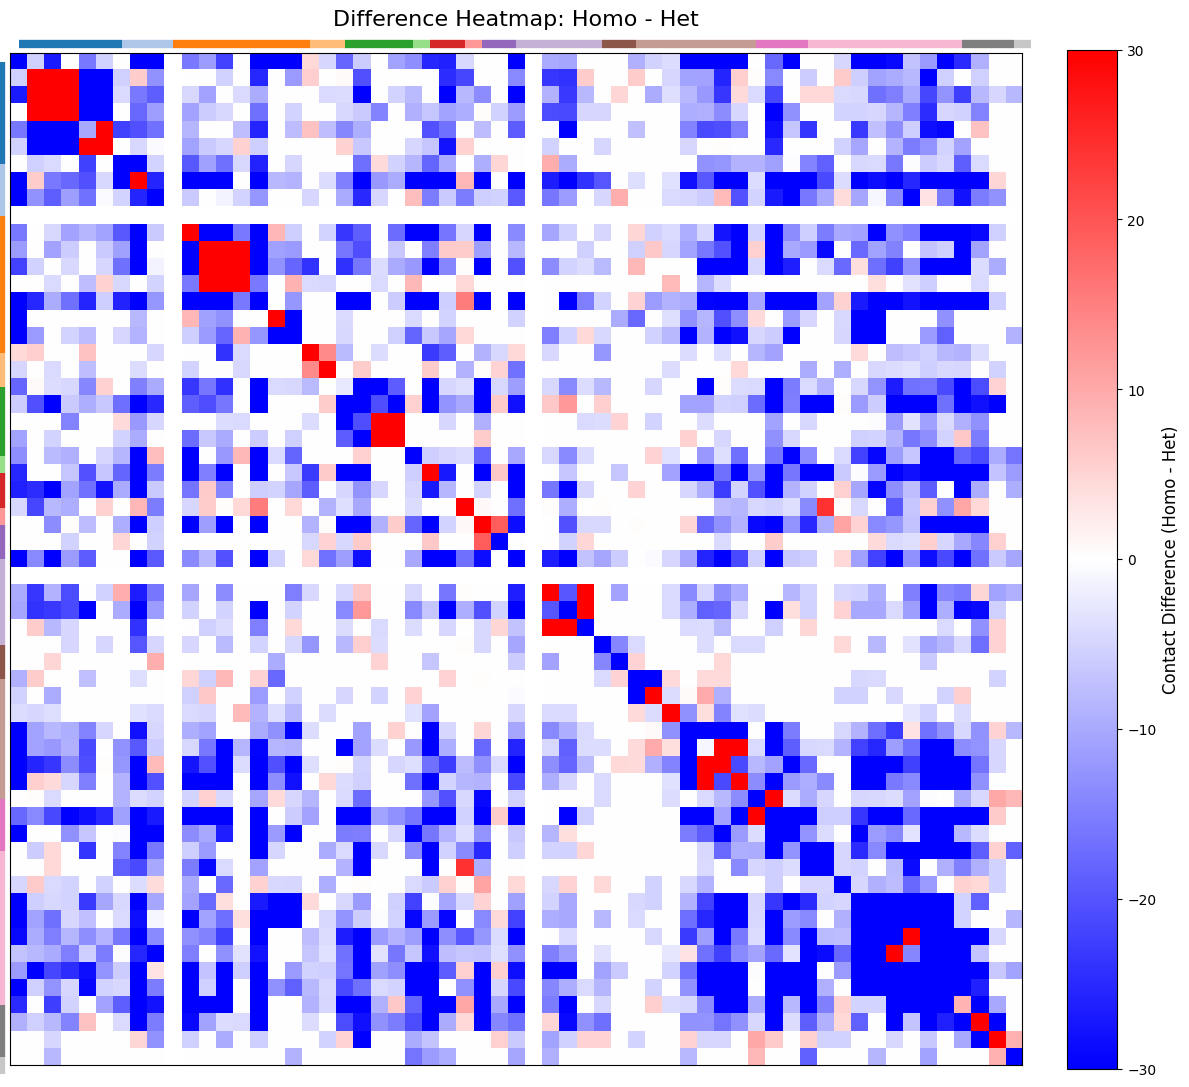

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable

# 差值矩阵（Homo - Het）
diff_mat = Homo_all_enhancer_normalized_contacts - Het_all_enhancer_normalized_contacts

# 染色体信息
chroms = unique_mapping['enhancer_chrom'].values
chrom_order = list(dict.fromkeys(chroms))  # 保持顺序去重
chrom_color_map = {chrom: plt.cm.tab20(i % 20) for i, chrom in enumerate(chrom_order)}

chrom_regions = []
for chrom in chrom_order:
    idxs = np.where(chroms == chrom)[0]
    if len(idxs) > 0:
        chrom_regions.append((chrom, idxs.min(), idxs.max()))

n = diff_mat.shape[0]

# 画图
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(diff_mat, cmap='bwr', interpolation='nearest', vmin=-30, vmax=30) 
ax.set_aspect('equal')  # 强制主图为方形

# 去掉刻度和标签
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Difference Heatmap: Homo - Het', fontsize=16, pad=20)

# 画x、y轴染色体彩条，覆盖完整格子
for chrom, start, end in chrom_regions:
    color = chrom_color_map[chrom]
    ax.plot([start, end + 1], [-1, -1], color=color, linewidth=6, solid_capstyle='butt', clip_on=False)  # X轴
    ax.plot([-1, -1], [start, end + 1], color=color, linewidth=6, solid_capstyle='butt', clip_on=False)  # Y轴

# 调整坐标轴范围，确保彩条显示
ax.set_xlim(-0.5, n - 0.5)
ax.set_ylim(n - 0.5, -0.5)


# 传入 im，生成颜色条
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Contact Difference (Homo - Het)', fontsize=12)

plt.tight_layout()
plt.savefig('../plots_v1/enhancer_contact_diff_heatmap_colored_chrom.pdf', dpi=300)
plt.show()
